In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os
import json
from Agent.utils import *
from Agent.data_agent import SalesDataAgent

<module 'langgraph.version' from '/Users/simop/miniconda3/lib/python3.11/site-packages/langgraph/version.py'>


In [10]:
# Optional: ensure deps (uncomment if needed)
# %pip install -q langgraph langchain-ollama duckdb pandas pyarrow matplotlib langchain-ollama

agent = SalesDataAgent(
    enable_tracing=True,
    phoenix_endpoint="http://localhost:6006/v1/traces",
    project_name="evaluating-agent",
    model="llama3.2:3b"
)
#ret = agent.run("What was the most popular product SKU?")
#print(ret.get("answer"))


Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: evaluating-agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



Server is running locally
Ollama is running locally


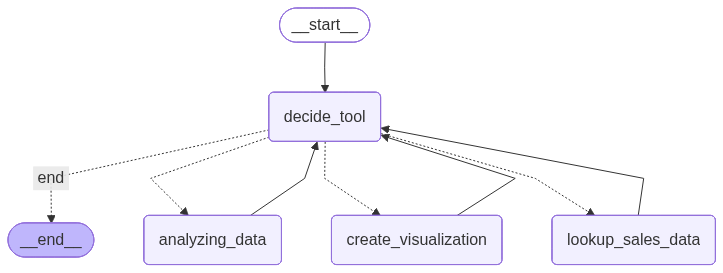

In [11]:
agent.check_model()
agent.draw_graph()

In [13]:
PREFIX = 'gpt'
DATASET_FILE_PATH = f"evaluation/{PREFIX}_dataset.json"
if os.path.exists(DATASET_FILE_PATH):
    with open(DATASET_FILE_PATH, 'r') as f:
        dataset = json.load(f)

ret = agent.run(dataset[13]['prompt'], lookup_only=True)
print('\n',ret)

TypeError: SalesDataAgent.run() got an unexpected keyword argument 'lookup_only'

In [84]:
#PREFIX = 'results/gptoss20-gpt'
PREFIX = 'gpt'
DATASET_FILE_PATH = f"evaluation/{PREFIX}_dataset.json"
if os.path.exists(DATASET_FILE_PATH):
    with open(DATASET_FILE_PATH, 'r') as f:
        dataset = json.load(f)

for i in range(len(dataset)):
    if (dataset[i].get('gen_sql') and dataset[i].get('gen_data')):
        print(f'\nSkipping question {i+1}/{len(dataset)} as generated results were already added.')
        continue
    print(f"------- Question {i+1}/{len(dataset)} -------")

    ret = agent.run(dataset[i]['prompt'], only_lookup=True)
    dataset[i]['gen_sql']=ret['sql_query']
    dataset[i]['gen_data']=ret['data']
    csv_path = f"evaluation/csv_queries/{PREFIX}_{i}_gen.csv"
    result_rows = text_to_csv(ret['data'])
    save_csv(result_rows, csv_path)
    dataset[i]["gen_csv_path"]=csv_path

with open(DATASET_FILE_PATH, 'w') as f:
    json.dump(dataset, f, indent=2)


Skipping question 1/21 as generated results were already added.

Skipping question 2/21 as generated results were already added.

Skipping question 3/21 as generated results were already added.

Skipping question 4/21 as generated results were already added.

Skipping question 5/21 as generated results were already added.

Skipping question 6/21 as generated results were already added.

Skipping question 7/21 as generated results were already added.

Skipping question 8/21 as generated results were already added.

Skipping question 9/21 as generated results were already added.

Skipping question 10/21 as generated results were already added.

Skipping question 11/21 as generated results were already added.

Skipping question 12/21 as generated results were already added.
------- Question 13/21 -------
Checking the model can run locally
Server is running locally
Ollama is running locally
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT Store_Number, SUM(CASE WHEN On_

In [69]:
PREFIX = 'claude'
DATASET_FILE_PATH = f"evaluation/{PREFIX}_dataset.json"
if os.path.exists(DATASET_FILE_PATH):
    with open(DATASET_FILE_PATH, 'r') as f:
        dataset = json.load(f)
i=1
data = dataset[i]
ret = best_of_n(
    agent, 
    data['prompt'],
    expected_csv=data['gt_csv_path'],
    csv_path=data['gen_csv_path'],
    n=3,
    temperature=[0.05,0.15] #Or also single values: 0.1
)


--- Attempt 1/3 (temperature=0.05) ---
Checking the model can run locally
Server is running locally
Ollama is running locally
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT SKU_Coded, SUM(Total_Sale_Value) 
FROM sales 
GROUP BY SKU_Coded 
ORDER BY SUM(Total_Sale_Value) DESC 
LIMIT 20;
Columns Names IoU: 1.00 -- Rows IoU: 0.00 -- Data IoU: 0.23
Score: 0.08

--- Attempt 2/3 (temperature=0.10) ---
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT SKU_Coded, SUM(Total_Sale_Value) 
FROM sales 
GROUP BY SKU_Coded 
ORDER BY SUM(Total_Sale_Value) DESC 
LIMIT 20;
Columns Names IoU: 1.00 -- Rows IoU: 0.00 -- Data IoU: 0.23
Score: 0.08

--- Attempt 3/3 (temperature=0.15) ---
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT SKU_Coded FROM sales WHERE Total_Sale_Value = ( SELECT MAX(Total_Sale_Value) FROM sales ) LIMIT 20
Columns Names IoU: 0.50 -- Rows IoU: 0.00 -- Data IoU: 0.00
Score: 0.00


In [78]:
#Evaluate best-of-n improvement
n=5
temperature = [0.1,0.3] #Or also single values: 0.1
PREFIX = 'gpt'

DATASET_FILE_PATH = f"evaluation/{PREFIX}_dataset.json"
if os.path.exists(DATASET_FILE_PATH):
    with open(DATASET_FILE_PATH, 'r') as f:
        dataset = json.load(f)

improvement = np.zeros(len(dataset))
for i in range(len(dataset)):
    #result_rows = text_to_csv(dataset[i]['gt_data'])
    #save_csv(result_rows, dataset[i]['gt_csv_path'])
    ret, improvement[i] = best_of_n(
        agent, 
        dataset[i]['prompt'],
        expected_csv=dataset[i]['gt_csv_path'],
        csv_path=dataset[i]['gen_csv_path'],
        n=n,
        temperature=temperature
    )

# Save results to CSV table
RESULTS_PATH = f"evaluation/results/best_of_n_improvement.csv"

# Create new results row
new_row = {
    'name': PREFIX,
    'n': n,
    'temperature': str(temperature), 
    'improvements': str(np.round(improvement,3)),
    'mean_improvement': round(improvement.mean(),3)
}

# Load existing results or create new dataframe
if os.path.exists(RESULTS_PATH):
    results_df = pd.read_csv(RESULTS_PATH)
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
else:
    results_df = pd.DataFrame([new_row])

# Save to CSV
results_df.to_csv(RESULTS_PATH, index=False)



--- Attempt 1/5 (temperature=0.10) ---
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT 
    CAST(Sold_Date AS VARCHAR) LIKE '%2023-%m%',
    SUM(Total_Sale_Value) AS total_revenue,
    SUM(Qty_Sold) AS total_units
FROM sales
GROUP BY CAST(Sold_Date AS VARCHAR) LIKE '%2023-%m%'
ORDER BY CAST(Sold_Date AS VARCHAR) LIKE '%2023-%m%' ASC
Columns Names IoU: 0.25 -- Rows IoU: 0.00 -- Data IoU: 0.00
Score: 0.00

--- Attempt 2/5 (temperature=0.15) ---
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT 
    CAST(Sold_Date AS VARCHAR) LIKE '%2023-%m%' AS month_start,
    SUM(Total_Sale_Value) AS total_revenue,
    SUM(Qty_Sold) AS total_units
FROM sales
GROUP BY CAST(Sold_Date AS VARCHAR) LIKE '%2023-%m%'
ORDER BY month_start ASC
Columns Names IoU: 1.00 -- Rows IoU: 0.00 -- Data IoU: 0.00
Score: 0.00

--- Attempt 3/5 (temperature=0.20) ---
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT 
    CAST(Sold_Date AS VARCHAR) LIKE '%2023-%m%' AS m